# 패키지 와 데이터 로드

In [30]:
import time
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn_extra.cluster import KMedoids

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
# from konlpy.tag import Komoran

# import pandas_datareader as pdr
from datetime import datetime

from scipy.cluster.hierarchy import linkage 
from scipy.cluster.hierarchy import dendrogram 

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

import scipy.spatial.distance as ssd

# from gensim.models import Word2Vec as w_to_v

In [31]:
#df.to_pickle('C:/Users/Dohyung/Desktop/데이터 마이닝/데이터 마이닝_프로젝트/ipynb/name,code,x1,x2,x3,x,x_nonumber,morph,morph_sum,labels_kse,labels_fics.fkl')
#df = pd.read_pickle('./name,code,x1,x2,x3,x,x_nonumber,morph,morph_sum,labels_kse,labels_fics.fkl')
df = pd.read_csv('./df.csv', encoding = 'euc-kr')
df_price = pd.read_pickle('./price_normal.fkl')
df_dtw_matrix = pd.read_pickle('./dtw_matrix.fkl')

df_finance = pd.read_pickle('./financial_i_log_categoric.fkl')
#df_finance = pd.read_csv('C:/Users/Dohyung/Desktop/데이터 마이닝/데이터 마이닝_프로젝트/Excel/financial_i.csv', encoding = 'euc-kr') #직접 수정본, log 스케일

# df_word = pd.read_csv('C:/Users/Dohyung/Desktop/데이터 마이닝/데이터 마이닝_프로젝트/Excel/khaiii_parsing.csv', encoding = 'euc-kr') #fnguide
df_dart = pd.read_csv('./dart.csv', encoding = 'euc-kr')
df_dart_origin = pd.read_pickle('./dart_crawling_result.fkl')
df_price = df_price.dropna(axis = 0)

In [32]:
df['labels_kse'].unique()

array(['전기,전자', '서비스업', '의약품', '화학', '운수장비', '은행', '철강및금속', '금융업', '유통업',
       '통신업', '전기가스업', '보험', '운수창고', '기계', '비금속광물', '제조업', '음식료품', '건설업',
       '증권', '섬유,의복', nan], dtype=object)

# 재무 지표 데이터 클러스터링

In [33]:
#Kmeans
finance_data = df_finance[["PER", "PBR", "PCR", "EV/EBITDA", "Dividend"]]
clst = KMeans(n_clusters=5)
clst.fit(finance_data)


clusters = clst.labels_.tolist()

centers = clst.cluster_centers_

<IPython.core.display.Javascript object>


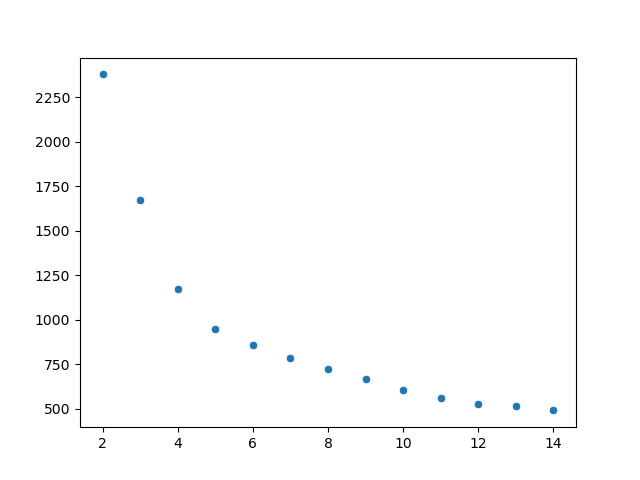

<AxesSubplot:>

In [34]:
# elbow 

clusters_range = list(range(2, 15))
inertia = []

for i in list(range(2, 15)):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(finance_data)
    inertia.append(kmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

In [35]:
# 실루엣.....?
# https://steadiness-193.tistory.com/285

from sklearn.metrics import silhouette_score

k_range = range(2, 15)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 100)
    kmeans.fit(finance_data)
    clusters = kmeans.predict(finance_data)
    
    score = silhouette_score(finance_data, clusters)
    print('k :', k, 'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n :', best_n, 'best score :', best_silhouette_score)

k : 2 score : 0.27603164465855556
k : 3 score : 0.4013148600204463
k : 4 score : 0.4108949563554528
k : 5 score : 0.29832870211164225
k : 6 score : 0.29013921591926434
k : 7 score : 0.25562976846832997
k : 8 score : 0.2884473299559834
k : 9 score : 0.27719833511785547
k : 10 score : 0.27224743358959846
k : 11 score : 0.23624661252437326
k : 12 score : 0.23890276905833777
k : 13 score : 0.2594398093577958
k : 14 score : 0.2378102641450267
best n : 4 best score : 0.4108949563554528


<IPython.core.display.Javascript object>


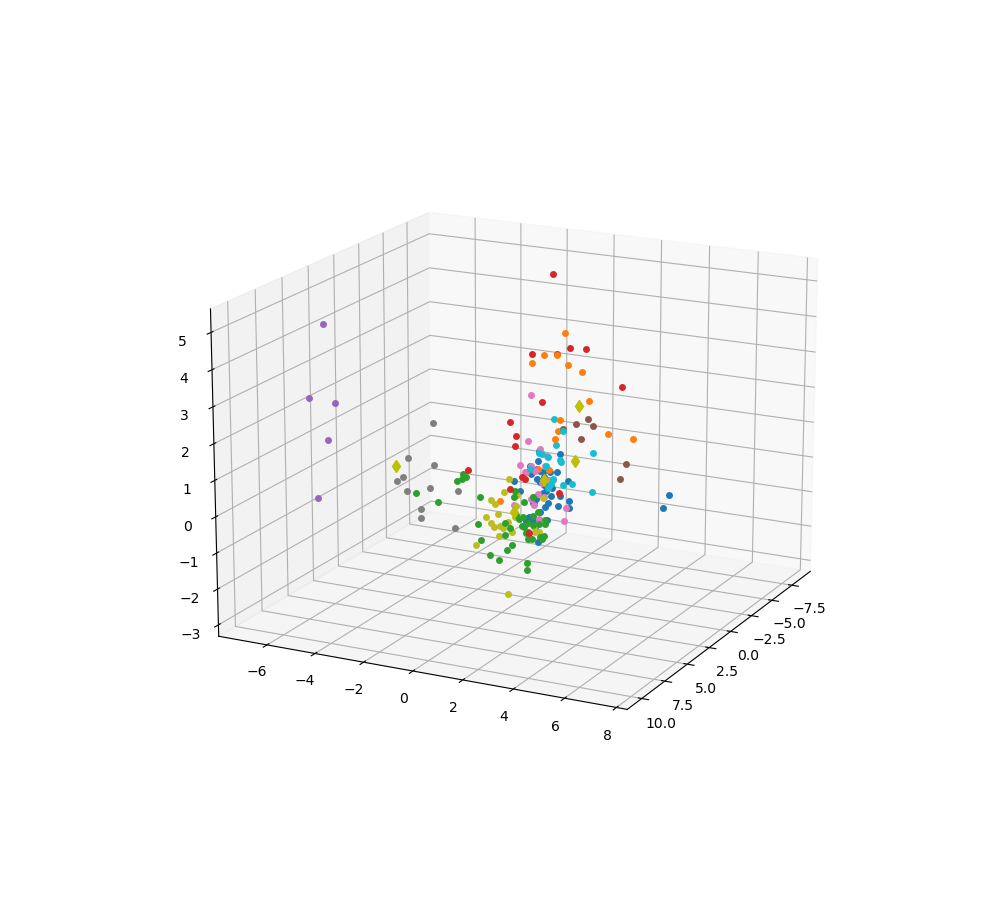

In [36]:
# PCA 차원 축소
%matplotlib notebook
using_pca = PCA(n_components=3)
using_pca.fit(finance_data)
pca= using_pca.transform(finance_data)
centers_trans= using_pca.transform(centers)

xs, ys, zs = pca[:, 0], pca[:, 1], pca[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()

# 토큰화

In [37]:
# !토크나이징
# 핵심

morphs=[]

komoran = Komoran(userdic='./my_dict.txt')
string_list = []
for i in range(0,200):
    noun = komoran.nouns(df_dart.iloc[i]['x2']) #morphs 로 하면, 형태소 단위로 다 쪼갬
    morphs.append(noun)
for j in range(0,200):
    every_morphs = komoran.pos(df_dart.iloc[j]['x2'])
    english = []
    for k in every_morphs:
        if k[1] == 'SL':
            english.append(k[0])

    morphs[j] += english

df_dart["morph"]= morphs






for i in range(0,200):
    sum_string = ""
    for j in range(0,len(df_dart.iloc[i]["morph"])):
        sum_string+= (df_dart.iloc[i]["morph"][j]+ " ")
    string_list.append(sum_string)
    
df_dart["morph_sum"] = string_list
df_dart

NameError: name 'Komoran' is not defined

In [38]:
with_dart = []
df_dartcopy = df_dart.copy()
df_copy = df.copy()

for i in range(0,200):
    A = df_dartcopy.iloc[i]["morph_dart"]
    B = df_copy.iloc[i]["morph_sum"]
    with_dart.append(A+B)
    
df["morph_sumdart"] = with_dart
df

,Unnamed: 0,name,code,x1,x2,x3,x,x_nonumber,morph,morph_sum,labels_kse,labels_fics,morph_sumdart,cluster
0,0,삼성전자,5930,"한국 및 CE, IM부문 해외 9개 지역총괄과 DS부문 해외 5개 지역총괄, Har...","세트사업에는 TV, 냉장고 등을 생산하는 CE부문과 스마트폰, 네트워크시스템, 컴퓨...","부품사업(DS부문)에서는 D램, 낸드 플래쉬, 모바일AP 등의 제품을 생산하는 반도...","한국 및 CE, IM부문 해외 9개 지역총괄과 DS부문 해외 5개 지역총괄, Har...","한국 및 CE, IM 부문 해외지역 총괄과 DS 부문 해외지역 총괄, Harman ...","['한국', '부문', '해외', '지역', '총괄', '부문', '해외', '지역...",한국 부문 해외 지역 총괄 부문 해외 지역 총괄 개 종속 기업 구성 글로벌 전자 기...,"전기,전자",휴대폰 및 관련부품,당사 본사 거점 한국 과 CE IM 부문 산하 해외 지역 총괄 DS 부문 산하 해외...,6
1,1,SK하이닉스,660,"1983년 현대전자로 설립됐고, 2001년 하이닉스반도체를 거쳐 2012년 최대주주...","주력 생산제품은 DRAM, 낸드플래쉬, MCP와 같은 메모리 반도체이며, 2007년...",2020년 10월 인텔의 NAND사업 양수를 결정함. 세계 반도체시장 점유율은 D...,"1983년 현대전자로 설립됐고, 2001년 하이닉스반도체를 거쳐 2012년 최대주주...","현대전자로 설립됐고, 하이닉스반도체를 거쳐 최대주주가 SK 텔레콤으로 바뀌면서 SK...","['현대전자', '설립', '하이', '닉스', '반도체', '최', '대주주', ...",현대전자 설립 하이 닉스 반도체 최 대주주 SK텔레콤 SK하이닉스 상호 변경 주력 ...,"전기,전자",반도체 및 관련장비,당사 현대 전자 산업 주식 회사 사명 변경 이후 주식회사 LG 반도체 합병 반도체 ...,11
2,2,NAVER,35420,"동사는 국내 1위 포털 서비스를 기반으로 광고, 쇼핑, 디지털 간편결제 사업을 영위...","웹툰, Zepeto, V LIVE 등 다양한 콘텐츠 사업을 통해서도 글로벌 사업 기...","네이버파이낸셜, 네이버 클라우드 등 연결대상 종속회사 76개를 보유함.","동사는 국내 1위 포털 서비스를 기반으로 광고, 쇼핑, 디지털 간편결제 사업을 영위...","동사는 국내 포털 서비스를 기반으로 광고, 쇼핑, 디지털 간편결제 사업을 영위하고 ...","['동사', '국내', '포털', '서비스', '기반', '광고', '쇼핑', '디...",동사 국내 포털 서비스 기반 광고 쇼핑 디지털 결제 사업 영위 공공 금융 분야 중심...,서비스업,인터넷 서비스,네이버 혁신 최고 서비스 글로벌 도전 집합체 A SET OF GLOBAL CHALL...,1
3,3,삼성바이오로직스,207940,"삼성그룹의 계열사로 2011년 4월 설립되었으며, 국내외 제약회사의 첨단 바이오의약...",2018년 cGMP 생산을 시작하여 2019년말 기준 36.2만리터 생산설비를 가동...,동사의 바이오의약품 연구개발 자회사인 삼성바이오에피스와 아키젠바이오텍은 바이오시밀러...,"삼성그룹의 계열사로 2011년 4월 설립되었으며, 국내외 제약회사의 첨단 바이오의약...","삼성 그룹의 계열사로 설립되었으며, 국내외 제약회사의 첨단 바이오의약품을 위탁 생산...","['삼성그룹', '계열사', '2011년 4월', '설립', '국내외', '제약',...",삼성그룹 계열사 2011년 4월 설립 국내외 제약 회사 첨단 바이오 의약품 위탁 생...,의약품,바이오,당사 바이오 의약품 위탁 생산 CMO 사업 세포주개발 공정 제형 분석법 세포주 개발...,4
4,4,LG화학,51910,"동사는 석유화학 사업부문, 전지 사업부문, 첨단소재 사업부문, 생명과학 사업부문, ...",연결회사는 2020년 12월 1일 전지 사업부문을 단순·물적분할하여 (주)LG에너지...,"동사는 양극재, 엔지니어링 소재, IT소재의 경쟁력을 바탕으로 고부가 제품을 중심으...","동사는 석유화학 사업부문, 전지 사업부문, 첨단소재 사업부문, 생명과학 사업부문, ...","동사는 석유화학 사업부문, 전지사업부문, 첨단소재사업부문, 생명과학사업부문, 공통 ...","['동사', '석유화학', '사업', '부문', '전지', '사업', '부문', '...",동사 석유화학 사업 부문 전지 사업 부문 첨단 소재 사업 부문 생명과학 사업 부문 ...,화학,화학,석유 화학 사업 납사 원료 에틸렌 프로필렌 부타디 벤젠 기초 유분 생산 공업 원료 ...,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,LX홀딩스,383800,동사는 인적분할로 설립된 신설회사로 2021년 5월 27일 유가증권시장에 재상장함.,"별도사업을 영위하지 않는 순수지주회사의 성격을 취하고 있으며 LX인터내셔널, LX하...","각 자회사들은 주요사업으로 상품중개업(LX인터내셔널), 건축용 플라스틱 제품제조업(...",동사는 인적분할로 설립된 신설회사로 2021년 5월 27일 유가증권시장에 재상장함....,동사는 인적분할로 설립된 신설회사로 유가증권시장에 재상장함 .별도 사업을 영위하지 ...,"['동사', '인적', '분할', '설립', '신설', '회사', '5월 27일',...",동사 인적 분할 설립 신설 회사 5월 27일 유가증권 시장 상장 별도 사업 영위 순...,금융업,복합 산업,당사 독점 규제 공정 거래 법률 상 지주 회사 기준 주식 회사 LX 인터내셔널 LX...,6
196,196,롯데하이마트,71840,"1987년 6월 하이마트로 설립된 동사는 가전제품 도소매업을 영위하며, 2020년말...",동사의 최대주주는 2008년 유진기업으로 변경된 후 2012년 10월 롯데쇼핑으로 ...,업계 1위 카테고리킬러업체로서 규모의 경제실현과 최고의 브랜드 인지도를 확보하고 있...,"1987년 6월 하이마트로 설립된 동사는 가전제품 도소매업을 영위하며, 2020년말...","하이마트로 설립된 동사는 가전제품도소매업을 영위하며, 기준 점포와 물류센터를 운영 ...","['6월', '하이', '마트', '설립', '동사', '가전제품', '도소매업',...",6월 하이 마트 설립 동사 가전제품 도소매업 영위 2020년 기준 점포 물류 센터 ...,유통업,도소매,가 사업 개요 당사 가전 제품 도 소매업 영위 매출 절대 비중 점포 가전 제품 판매...,5
197,197,LX하우시스,108670,동사는 LG그룹 계열사로 2009년 LG화학 산업재 사업부문이 분할돼 설립된 기업임.,"동사의 주요제품은 창호, 바닥재, 인조대리석 등의 건축자재와 자동차부품/원단, 인테...","동사는 국내 뿐 아니라 중국, 북미, 유럽 등의 핵심 시장에서 고객 중심의 사업 활...",동사는 LG그룹 계열사로 2009년 LG화학 산업재 사업부문이 분할돼 설립된 기업임...,동사는 LG 그룹 계열사로 LG 화학산업재 사업부문이 분할돼 설립된 기업임.동사의 ...,"['동사', 'LG그룹', '계열사', 'LG화학', '산업', '사업', '부문'...",동사 LG그룹 계열사 LG화학 산업 사업 부문 분할 설립 기업 동사 제품 호 바닥재...,화학,건축자재,당사 종속 회사 포함 건축 자재 부문 자동 차 소재 산업 필름 부문 사업 부문 구성...,5
198,198,삼양식품,3230,"동사는 1961년 유지공업과 식품도매업을 영위하기 위하여 설립되었으며, 면류, 스낵...",1960년대 식량난 극복을 위해 1963년 9월 국내 최초로 '삼양라면'을 생산함....,"미국, 러시아, 유럽을 비롯하여 중국, 동남아, 중동 등 세계 각지에 삼양라면, 불...","동사는 1961년 유지공업과 식품도매업을 영위하기 위하여 설립되었으며, 면류, 스낵...","동사는 유지공업과 식품 도매업을 영위하기 위하여 설립되었으며, 면류, 스낵류, 유제...","['동사', '유지', '공업', '식품', '도매', '영위', '설립', '면류..."

# 기업 개요 데이터 클러스터링

In [39]:
#TFidf 변환 및 KMeans 학습

countvectorizer = CountVectorizer(stop_words=['1월', '1일','2월','3월','4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월', 'M', 'co', 'company', 'global', 'inc', '가능', '가능', '가치', '각종', 
                                              '감소', '강화', '개', '개선', '개시', '개요', '거점', '결과', '결정', '경영', 
                                              '경우', '경쟁력', '계속', '계획', '공시', '과정', '관련', '관리', '구분', 
                                              '구성', '구조', '구축', '국가', '국내', '국내외', '규모', '극대', '글로벌', 
                                              '기간', '기능', '기대', '기록', '기반', '기업', '기존', '기준', '기초',
                                              '기타', '기회', '내용', '노력', '누적', '능력', '다각', '다수', '다양', '다음',
                                              '단계', '단위', '단일', '달성', '담당', '당기', '당사', '대비', '대상', '대응',
                                              '도약', '도입', '동기', '동력', '동사', '동시', '드', '등', '마련', '매출', 
                                              '매출액', '목적', '목표', '및', '바탕', '반기', '반영', '방식', '법인', '변경',
                                              '변동', '변화', '별도', '보수', '보호', '부가', '부문', '부분', '분기', '분류',
                                              '분야', '비용', '비중', '사업', '사업장', '사용', '사항', '상기', '상반기', 
                                              '상승', '상장', '상호', '상황', '선도', '설계', '설립', '설비', '성격', '성장',
                                              '세계', '소유', '수요', '수익', '수준', '수출', '수행', '시작', '시장', '시행',
                                              '실적', '아래', '안정', '업무', '업체', '역량', '역할', '연간', '연결', '영역', 
                                              '영업', '영위', '영향', '예상', '예정', '완료', '요구', '요약', '요인', '우수', 
                                              '우위', '운영', '위주', '위치', '유가증권', '유지', '의', '이상', '이익', '이하', 
                                              '이후', '일반', '일부', '임대', '입지', '자금', '자본', '자산', '자체', '작성', 
                                              '장기', '장벽', '장점', '재무', '적극', '적용', '전개', '전년', '전년 동기', 
                                              '전략', '전망', '전문', '전반', '전체', '점유', '제고', '제외', '제품', '조정', '조직', 
                                              '종속', '종합', '주', '주도', '주력', '주식', '주식회사', '주요', '준비', '중심',
                                              '중요', '증가', '증대', '지배', '지분', '지속', '지역', '지원', '지위', '지주',
                                              '지주회사', '진행', '집중', '차별', '차지', '참고', '참여', '참조', '창출',
                                              '채널', '처리', '체계', '체제', '최고', '최근', '최대', '최소', '최초',
                                              '추가', '추세', '추진', '충족', '투자', '특성', '특수', '특징', '평가',
                                              '포함', '필요', '항목', '해당', '해외', '핵심', '향상', '향후', '현재', '현지',
                                              '현황', '형태', '확대', '확보', '확장', '활동', '활용', '회사', '효율'], 
                                  ngram_range=(1,2), max_df = 0.4, min_df = 0.05, lowercase=True, max_features = 550) #0.4 0.05
tfidftransformer = TfidfTransformer()

data = df["morph_sumdart"].copy()
data_trans = tfidftransformer.fit_transform(countvectorizer.fit_transform(data))


clst = KMeans(n_clusters=10, random_state=0)
clst.fit(data_trans)


clusters = clst.labels_.tolist()

centers = clst.cluster_centers_

In [40]:
print(data_trans.shape)

(200, 550)


In [41]:
countvectorizer.stop_words_

{'통영 lng',
 '매출처 보장',
 'ai 클라우드',
 '나머지 플랫폼',
 '도매 유통',
 '초안 생산',
 '증권 인적분할',
 '개국 타이어',
 '하락 매크',
 '원수사',
 '계열 ech',
 '지수 전분기말',
 '관리자지수',
 '보증 서비스',
 '공정 일정',
 '선망',
 '전용 화물터',
 '금년 평균',
 '전력제어 ict',
 '발전 원유',
 '엔터테인먼트 라이프스타일',
 '합작 신규',
 '당분기말 ict',
 '상실 청산',
 '방학 시즌',
 '대표 홍삼',
 '경기 비교',
 '매트리스 메모리폼',
 '집행 금년도',
 '면전',
 '시운전 시운전',
 '뚜기베트 당반기',
 'ip 기획',
 '서비스 활성',
 '소비량',
 '지지핀',
 '판단 개황',
 '피탈 새마을금고중앙회',
 '소셜카 온라인',
 '시기 중후반',
 '자동차보험 손해',
 'lng 정유',
 '아시아나항공 외항기',
 '개발 신재생',
 '전동 경기도',
 '세종 연료',
 '기술 겸비',
 '판매 포브스',
 '신세계동대구복합',
 '생산지 소비지',
 '이마트 소매상',
 '운송업 정치',
 '제법',
 'pc 생활',
 '화승비',
 '기획 제작',
 '대전 공장',
 '난방 취사',
 '해석 적외선',
 '한국 부동산',
 '카카오엔터프라이즈 미래',
 '충격 경기',
 'textile',
 '조치 배관망',
 '포트폴리오 본점',
 '타이어 신발',
 '질소산화물 황산',
 '비상 이징',
 '주택 가격',
 '표준 고무',
 '린본드',
 '탐험심',
 '요소 작용',
 '근태',
 '신규 매장',
 '송림푸드',
 '단조',
 'si 서비스',
 '에피스',
 '표면재 산업',
 '재편',
 '디지털이노베이션',
 'bulk 현대',
 '항공기 운항',
 '보험료 이자',
 '가동 hyosung',
 '증권 출자',
 '천연 발효',
 '대합실',
 'sk네트웍스서비스',
 '대만 중국',
 '인프라 석유화학',
 '주자 풍력

In [42]:
countvectorizer.vocabulary_

{'본사': 190,
 '한국': 514,
 '전자': 397,
 'tv': 19,
 '스마트폰': 266,
 '네트워크': 107,
 '시스템': 273,
 '부품': 195,
 '모바일': 150,
 '반도체': 163,
 '디스플레이': 133,
 '인수': 362,
 '디지털': 135,
 '삼성': 212,
 '대리점': 113,
 '운송': 323,
 '유럽': 340,
 '중동': 431,
 '아시아': 291,
 '연구': 306,
 '미국': 157,
 '복합': 187,
 'sk': 17,
 '가전': 28,
 '중국': 430,
 'vietnam': 20,
 '상세': 214,
 '매출처': 147,
 '생산 판매': 223,
 '현대': 527,
 '사명': 206,
 'lg': 10,
 '합병': 517,
 '그룹': 88,
 '편입': 499,
 '독일': 124,
 '일본': 370,
 '인도': 359,
 '설치': 236,
 '시설': 272,
 '정보': 406,
 '저장': 389,
 '반면': 164,
 '소재': 250,
 '준공': 429,
 'ii': 6,
 '진출': 443,
 '생산 생산': 222,
 '혁신': 525,
 '첨단': 453,
 '경험': 53,
 '환경': 538,
 '동안': 129,
 '선제': 235,
 '인터넷': 368,
 '광고': 79,
 '커머스': 472,
 '콘텐츠': 476,
 '금융': 92,
 '솔루션': 253,
 '포트폴리오': 501,
 '성장세': 241,
 '한편': 515,
 '수주': 262,
 '쇼핑': 255,
 '공공': 67,
 '인프라': 369,
 '솔루션 제공': 254,
 '바이오': 162,
 '의약품': 349,
 '위탁': 335,
 '공정': 74,
 '초기': 456,
 '임상': 372,
 '경제': 51,
 '상업': 215,
 '자회사': 382,
 '제약': 412,
 '니즈': 109,
 '대형': 120,
 '경쟁사': 50,
 

<IPython.core.display.Javascript object>


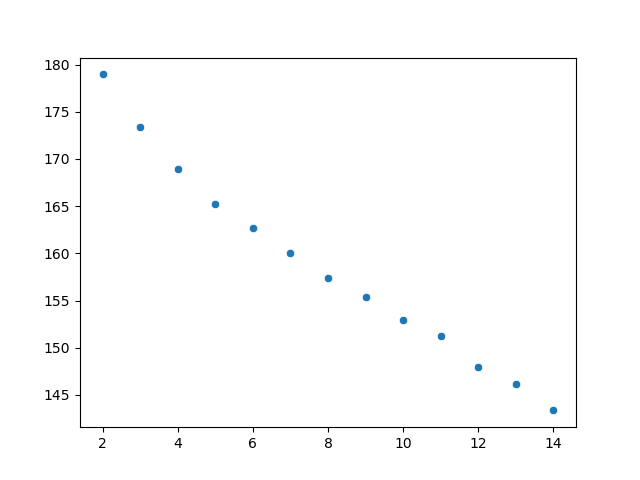

<AxesSubplot:>

In [43]:
# elbow --> 엘보우 포인트가 확실하지 않음

clusters_range = list(range(2, 15))
inertia = []

for i in list(range(2, 15)):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data_trans)
    inertia.append(kmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

In [44]:
# 실루엣.....?
# https://steadiness-193.tistory.com/285

from sklearn.metrics import silhouette_score

k_range = range(2, 25)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 100)
    kmeans.fit(data_trans)
    clusters = kmeans.predict(data_trans)
    
    score = silhouette_score(data_trans, clusters)
    print('k :', k, 'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n :', best_n, 'best score :', best_silhouette_score)

k : 2 score : 0.026018336913953076
k : 3 score : 0.04030776125835501
k : 4 score : 0.04581215283328104
k : 5 score : 0.040843852044757864
k : 6 score : 0.0465439631885046
k : 7 score : 0.05249972072659949
k : 8 score : 0.0537423949569694
k : 9 score : 0.05147941459400147
k : 10 score : 0.05509032000128752
k : 11 score : 0.05542039245767289
k : 12 score : 0.057110736096453465
k : 13 score : 0.06054246140451259
k : 14 score : 0.05702684452806132
k : 15 score : 0.05611114183795461
k : 16 score : 0.060800771258492904
k : 17 score : 0.06171066973392106
k : 18 score : 0.06860283381361477
k : 19 score : 0.0659404525107906
k : 20 score : 0.06520389958116529
k : 21 score : 0.07045117707827511
k : 22 score : 0.07317685160552474
k : 23 score : 0.08047160996442349
k : 24 score : 0.0719835135897392
best n : 23 best score : 0.08047160996442349


In [45]:
#계층적 클러스터링(강의버젼)

hac = linkage(tfidf_matrix, 'ward') #single, average, complete, weighted, centroid, median, ward
plt.figure(figsize=(10, 7))
labelList = range(1,201)
dendrogram(hac,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

NameError: name 'tfidf_matrix' is not defined

<IPython.core.display.Javascript object>


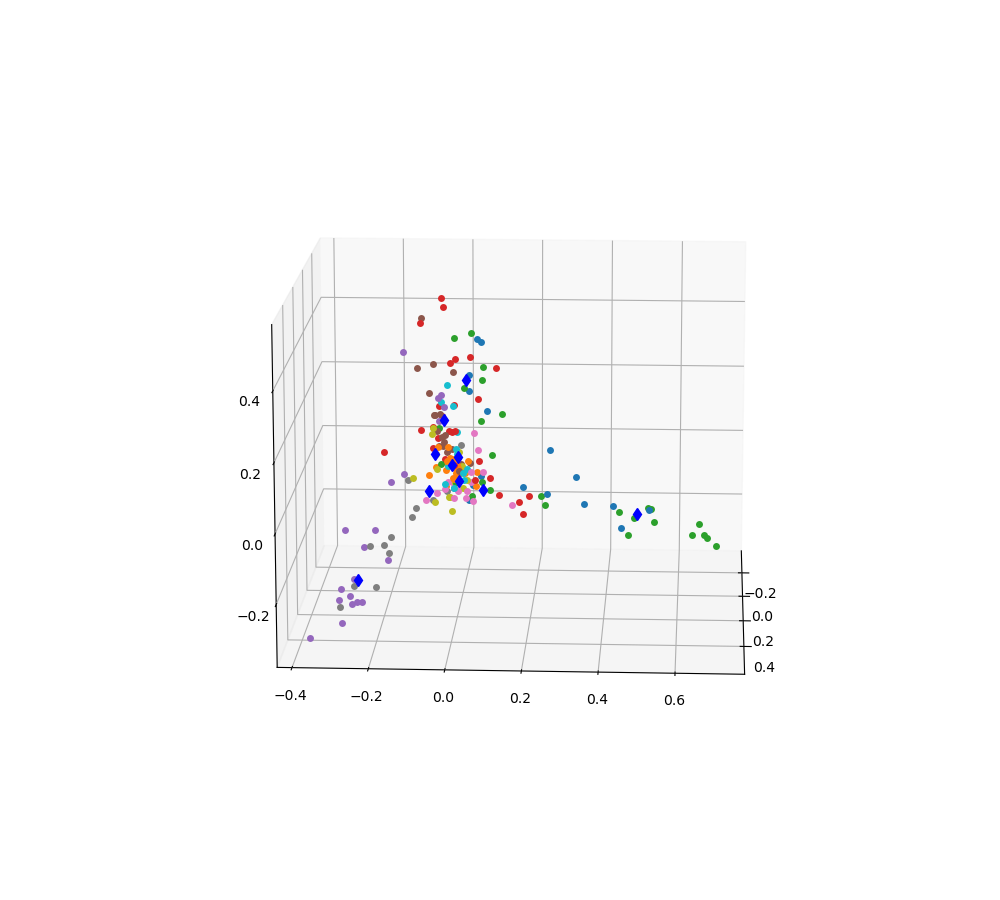

In [46]:
# PCA 차원 축소
#%matplotlib notebook
using_pca = PCA(n_components=3)
using_pca.fit(data_trans.toarray())
pca= using_pca.transform(data_trans.toarray())
centers_trans= using_pca.transform(centers)

xs, ys, zs = pca[:, 0], pca[:, 1], pca[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='b', zorder=100, marker='d', linestyle='')
plt.show()

In [47]:
# 데이터 프레임 형태로 클러스터 결과 확인

df["cluster"]= clusters

df_groupby_cluster = df.groupby('cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df.groupby('cluster')['labels_kse'].apply(list)

for i in groupby_list:
    print(i)
    print('\n')


['전기,전자', '운수장비', '전기,전자', '화학', '철강및금속']


['화학', '화학', '기계', '금융업', '화학', '기계', '화학']


['의약품', '서비스업', '금융업', '의약품', '의약품', '금융업', '의약품', '의약품', '의약품', '의약품', '의약품', '의약품']


['서비스업', '서비스업', '서비스업', '서비스업', '통신업', '음식료품', '음식료품', '서비스업', '서비스업', '제조업', '유통업']


['은행', '금융업', '금융업', '금융업', '금융업', '은행', '증권', '금융업', '증권', '증권', '증권', '금융업', '증권']


['서비스업', '운수창고', '운수창고', '운수창고', '운수창고', '운수창고', '운수창고', '서비스업', '유통업', '기계', '금융업', '운수창고', '유통업', nan]


['화학', '기계', '화학', '화학', '화학', '금융업', '화학', '화학', '섬유,의복', '금융업']


['전기,전자', '금융업', '전기가스업', '서비스업', '금융업', '제조업', '유통업', '기계']


['운수장비', '운수장비', '운수장비', '기계', '운수장비', '운수장비', '화학', '운수장비', '금융업', '전기,전자', '운수장비', '화학']


['음식료품', '음식료품', '화학', '금융업', '금융업', '금융업']


['화학', '화학', '의약품', '화학', '유통업', '화학', '화학']


['기계', '건설업', '서비스업', '전기,전자', '전기가스업', '비금속광물', '운수장비', '건설업', '건설업', '건설업', '서비스업', '건설업', '건설업', '비금속광물']


['전기,전자', '통신업', '금융업', '비금속광물', '화학', '전기,전자', '유통업']


['화학', '화학', '전기,전자', '화학', '금융업', '화학', '운수장비', '금융업',

In [20]:
# 데이터 프레임 형태로 클러스터 결과 확인

df["cluster"]= clusters

df_groupby_cluster = df.groupby('cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df.groupby('cluster')['name'].apply(list)

for i in groupby_list:
    print(i)
    print('\n')

['NAVER', '카카오', '크래프톤', 'SK텔레콤', '엔씨소프트', '하이브', '삼성전기', '넷마블', 'KT', 'LG유플러스', '에스원', '한화시스템', '제일기획', 'SK네트웍스', '더블유게임즈', '이노션', '태광산업', 'LIG넥스원']


['LG', 'S-Oil', '고려아연', '한화솔루션', '한국조선해양', '강원랜드', '현대제철', '금호석유', '한국타이어앤테크놀로지', '현대중공업지주', '이마트', 'GS', '한미사이언스', '호텔신라', '롯데지주', 'GS리테일', '한국항공우주', '롯데쇼핑', '포스코인터내셔널', '현대미포조선', '한화', '한화에어로스페이스', 'LS', '현대엘리베이', '대한전선', 'LS ELECTRIC', '한국앤컴퍼니', '금호타이어', '롯데관광개발', 'DL', '녹십자홀딩스', '대한유화', 'CJ CGV', 'GKL', 'SK디스커버리', '넥센타이어', '롯데하이마트']


['삼성물산', 'LG생활건강', 'KT&G;', '아모레퍼시픽', 'CJ제일제당', '오리온', '아모레G', '동서', '하이트진로', '신세계', '휠라홀딩스', '영원무역', '오뚜기', '농심', '동원시스템즈', 'F&F;홀딩스', '코스맥스', '롯데칠성', '신세계인터내셔날', '지누스', '한섬', '오리온홀딩스', '쿠쿠홈시스', '한세실업', '대상', '쿠쿠홀딩스', '동원F&B;', '삼양식품']


['카카오뱅크', 'KB금융', '신한지주', '삼성생명', '하나금융지주', '삼성화재', '우리금융지주', '기업은행', '미래에셋증권', '한국금융지주', 'DB손해보험', '삼성증권', '삼성카드', 'NH투자증권', '메리츠증권', '한화생명', 'BNK금융지주', '키움증권', '현대해상']


['현대차', '기아', '현대모비스', 'SK아이이테크놀로지', '롯데케미칼', '한온시스템', '코웨이', 'LG이노텍', '효성첨단소재', 'KCC', '만도', '코

<IPython.core.display.Javascript object>


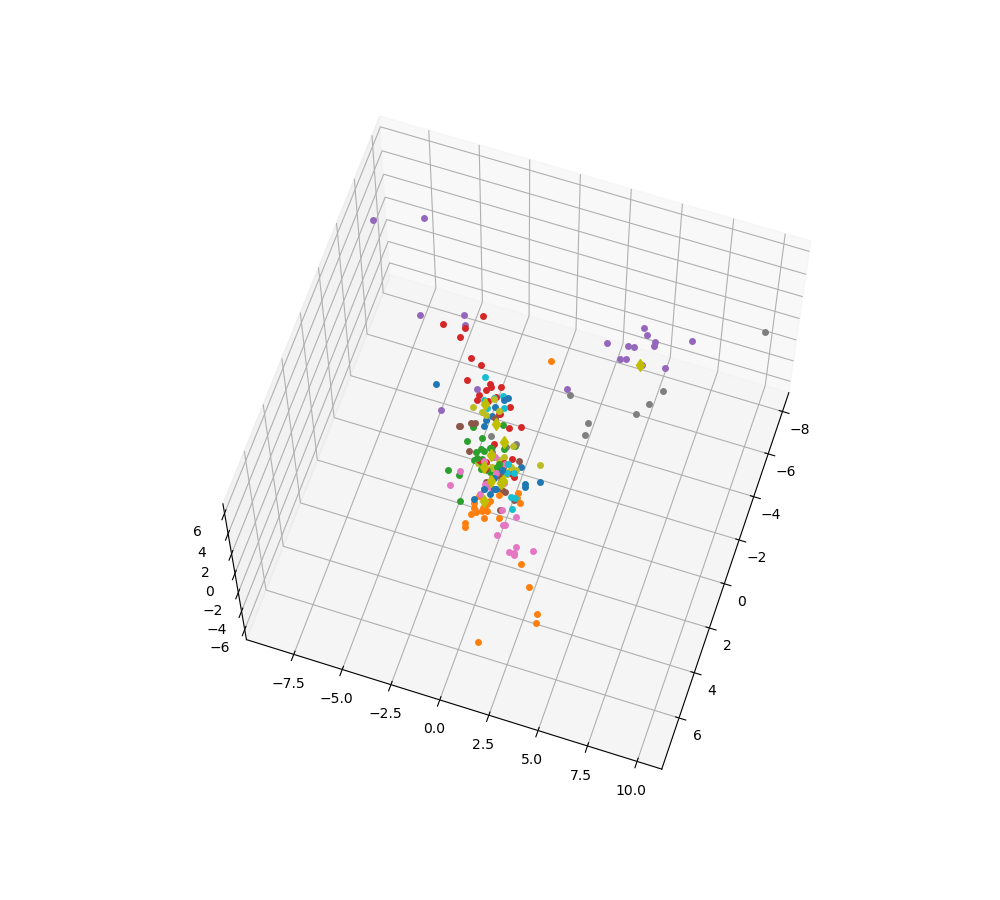

In [48]:
#LDA 차원축소
lda = LinearDiscriminantAnalysis(n_components=3)

#학습
lda.fit(data_trans.toarray(), clusters)
#변형
data_lda = lda.transform(data_trans.toarray())
centers_trans= lda.transform(centers)

#DataFrame 생성
lda_columns=['lda_component_1','lda_component_2','lda_component_3']
DF_lda = pd.DataFrame(data_lda, columns=lda_columns)
DF_lda['target']=clusters


#축 지정
xs, ys, zs = data_lda[:, 0], data_lda[:, 1], data_lda[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')

markers=['^', 's', 'o','d','*']
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none' )
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()



# 주가 변동 데이터 클러스터링

## 클러스터링 알고리즘 선택

In [49]:
#시계열 KMeans
n_clusters = 20
tsclst = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean') #'euclidean', 'dtw'
tsclst.fit(df_price)

clusters = tsclst.labels_.tolist()

centers = tsclst.cluster_centers_

<IPython.core.display.Javascript object>


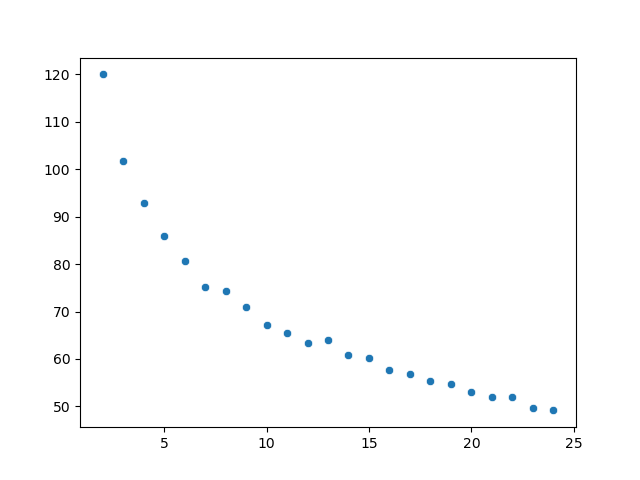

<AxesSubplot:>

In [50]:
# elbow 

clusters_range = list(range(2, 25))
inertia = []

for i in list(range(2, 25)):
    tskmeans = TimeSeriesKMeans(n_clusters = i, metric='euclidean')
    tskmeans.fit(df_price)
    inertia.append(tskmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

<IPython.core.display.Javascript object>


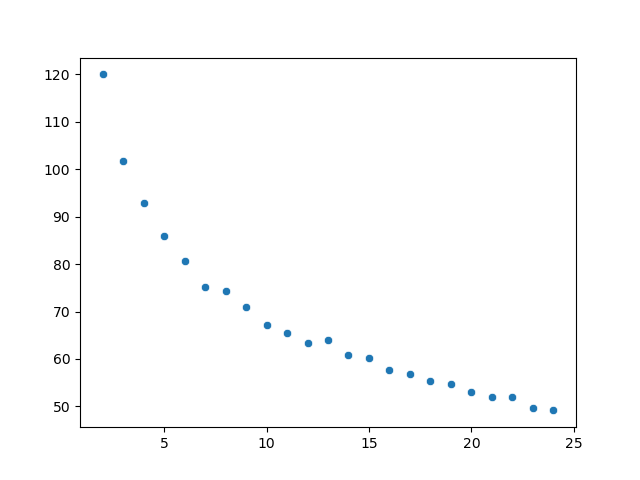

<AxesSubplot:>

In [51]:
sns.scatterplot(x=clusters_range, y=inertia)

In [52]:
len(tsclst.labels_)

194

In [53]:
# 실루엣.....?
# https://steadiness-193.tistory.com/285

from sklearn.metrics import silhouette_score

k_range = range(2, 10)
best_n = -1
best_silhouette_score = -1

for k in k_range:
    stskmeans = TimeSeriesKMeans(n_clusters = k, metric = 'euclidean')
    stskmeans.fit(df_price)
    clusters = stskmeans.labels_
    
    score = silhouette_score(df_price, labels = clusters)
    print('k :', k, 'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score = score
        
print('best n :', best_n, 'best score :', best_silhouette_score)

k : 2 score : 0.3024277788917913
k : 3 score : 0.2191612675101462
k : 4 score : 0.2008088617816136
k : 5 score : 0.1876222261260084
k : 6 score : 0.13877210423043132
k : 7 score : 0.14710635931925622
k : 8 score : 0.1267873200866755
k : 9 score : 0.11503779736934736
best n : 2 best score : 0.3024277788917913


<IPython.core.display.Javascript object>


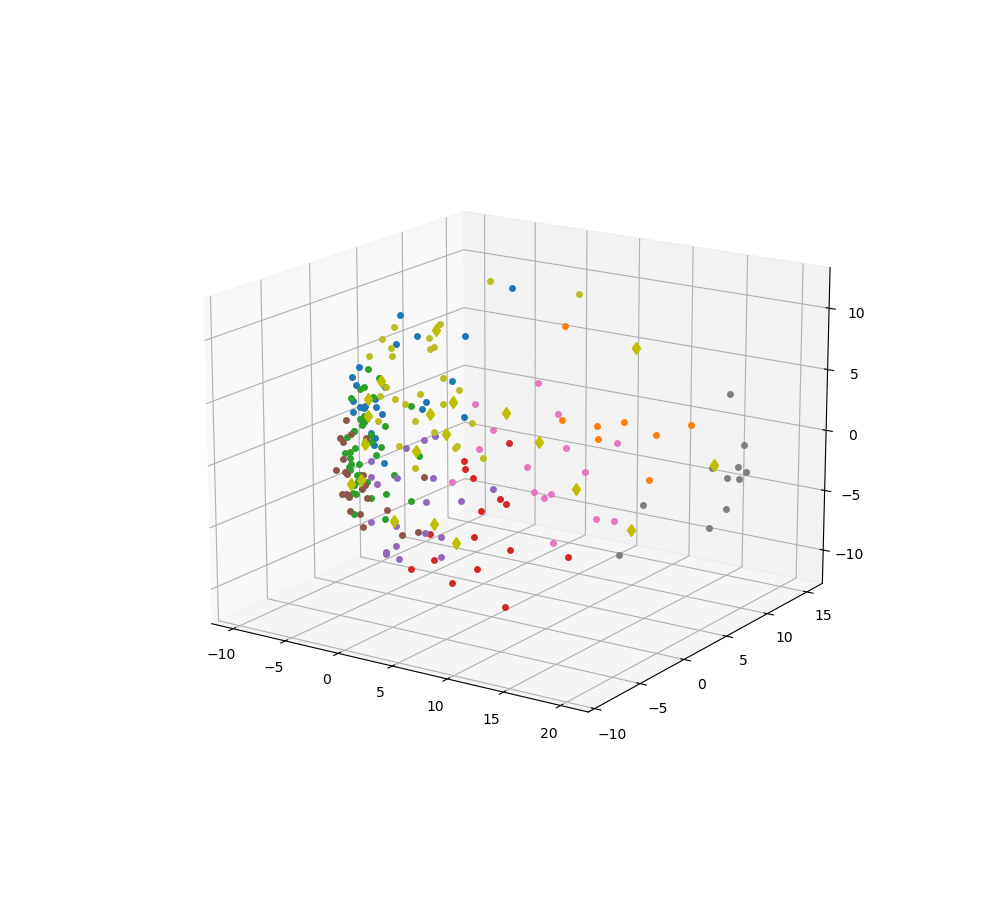

In [54]:
%matplotlib notebook
#pca 차원축소
using_pca = PCA(n_components=3)
using_pca.fit(df_price)
pca= using_pca.transform(df_price)
centers_trans= using_pca.transform(centers.reshape(n_clusters,248))

xs, ys, zs = pca[:, 0], pca[:, 1], pca[:, 2]

df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w',-1:'y'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()

<IPython.core.display.Javascript object>


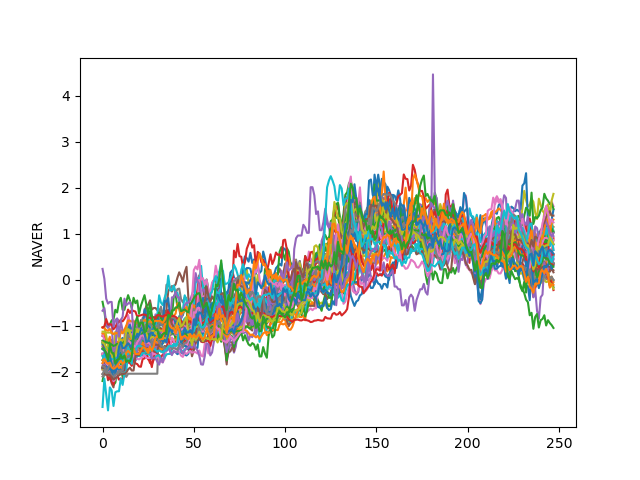

In [55]:
df_price["cluster"] = clusters
index = []
cluster0 = df_price.query("cluster==2")
cluster0 = cluster0.drop("name", axis=1, errors = 'ignore')
cluster0 = cluster0.drop("cluster", axis=1, errors = 'ignore')
for i in range(0, len(cluster0)):
    sns.lineplot(y = cluster0.iloc[i], x = list(range(248)))


<IPython.core.display.Javascript object>


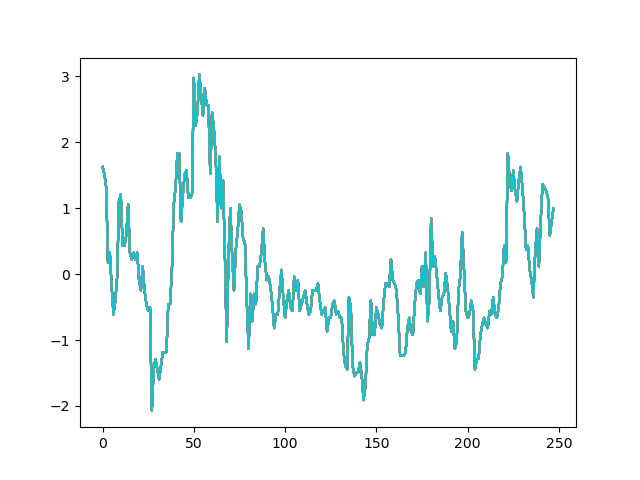

In [56]:
centers_price = centers.reshape(n_clusters,248)
for i in range(0, n_clusters):
    sns.lineplot(y = centers_price[2], x = list(range(248)))
    

In [57]:
# 데이터 프레임 형태로 클러스터 결과 확인

df_price["cluster"]= clusters
df_price["name"]= df_price.index

df_groupby_cluster = df_price.groupby('cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df_price.groupby('cluster')["name"].apply(list)

for i in groupby_list:
    print(i)
    print('\n')
df_price = df_price.drop("name",axis=1, errors = 'ignore')
df_price = df_price.drop("cluster",axis=1, errors = 'ignore')

['삼성SDI', '기아', 'SK이노베이션', 'LG전자', 'SK', '삼성전기', '포스코케미칼', '대한항공', 'CJ제일제당', 'LG이노텍', '이마트', 'GS건설', 'OCI', '한화시스템', '한국항공우주', '만도', '씨에스윈드', 'CJ', '한화', 'DB하이텍', '현대위아', 'LS ELECTRIC', 'HDC현대산업개발', '동원시스템즈', '대웅제약', '세방전지', 'CJ CGV']


['셀트리온', '유한양행', '두산퓨얼셀', '에스원', '녹십자', '대웅', '녹십자홀딩스', '종근당', '부광약품']


['NAVER', '카카오', 'POSCO', 'SK텔레콤', '신한지주', '하나금융지주', '하이브', 'HMM', 'S-Oil', 'KT', 'SKC', 'LG유플러스', '강원랜드', '현대제철', '현대건설', '현대중공업지주', 'GS', '쌍용C&E;', '두산밥캣', 'NH투자증권', '호텔신라', '팬오션', '제일기획', '포스코인터내셔널', '한샘', '효성티앤씨', '현대로템', '현대미포조선', '한전기술', '한화에어로스페이스', '현대엘리베이', '한전KPS', '동국제강', '금호타이어', '코스맥스', '롯데칠성', '영풍', '태광산업', '오리온홀딩스', '삼양홀딩스', '동원F&B;', '넥센타이어', 'LX하우시스']


['삼성물산', 'LG생활건강', '한국전력', '넷마블', '현대글로비스', '한미사이언스', '롯데지주', '대우조선해양', '휠라홀딩스', 'LS', '농심', '이노션', '지누스', '현대홈쇼핑', '대상', '현대두산인프라코어']


['삼성전자', '현대차', 'LG', '삼성생명', '아모레퍼시픽', '한온시스템', '한국조선해양', 'LG디스플레이', '금호석유', '아모레G', 'GS리테일', 'CJ대한통운', '롯데쇼핑', '아이에스동서', '더블유게임즈', '한국콜마', '보령제약', '동원산업', 'SNT모티브', '롯데하이마트']


[

In [58]:
df_price

Date,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,...,2021-10-08,2021-10-12,2021-10-13,2021-10-14,2021-10-15,2021-10-18,2021-10-19,2021-10-20,2021-10-21,2021-10-22
삼성전자,-2.477094,-2.463069,-2.435020,-2.519168,-2.631364,-2.757586,-2.967955,-2.855758,-2.659414,-2.701487,...,-0.878290,-1.228905,-1.256954,-1.172807,-1.074634,-1.060610,-1.004512,-1.046585,-1.060610,-1.032561
SK하이닉스,-2.159880,-2.122838,-2.166054,-2.203095,-2.184574,-2.258658,-2.369784,-2.388305,-2.277179,-2.166054,...,-1.499300,-1.653641,-1.622773,-1.511647,-1.227659,-1.307917,-1.270875,-1.258528,-1.357306,-1.221486
NAVER,-1.418506,-1.542362,-1.637636,-1.599526,-1.313705,-1.313705,-1.475670,-1.561417,-1.609054,-1.313705,...,0.401226,0.086822,0.277370,0.525082,0.496500,0.553664,0.763267,0.763267,0.820431,0.763267
삼성바이오로직스,-2.306606,-2.606760,-2.688620,-2.620404,-2.593117,-1.774516,-1.979166,-1.760872,-1.747229,-1.283355,...,0.040050,0.094623,0.026406,0.435707,0.572141,0.422064,0.558497,0.654001,0.558497,0.722217
LG화학,-2.365395,-2.232747,-2.280983,-2.449808,-2.329218,-2.220688,-2.703045,-2.558338,-2.160394,-2.232747,...,-0.858031,-0.472145,-0.327438,0.154918,0.010211,-0.098319,-0.050083,0.058447,-0.351556,-0.206849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
현대두산인프라코어,0.041122,-0.006779,-0.026502,-0.032137,-0.015232,-0.060314,-0.091308,-0.068767,-0.043408,-0.080038,...,-1.624592,-1.624592,-1.624592,-1.624592,-1.624592,-1.624592,-1.624592,-1.624592,-1.624592,-1.624592
롯데하이마트,-0.856272,-0.780919,-1.069770,-0.994417,-0.944183,-1.207916,-1.182798,-1.132563,-1.157681,-1.182798,...,-1.747940,-1.911204,-1.773058,-1.873528,-1.697706,-1.660029,-1.660029,-1.773058,-1.773058,-1.735382
LX하우시스,-1.494259,-1.520963,-1.583271,-1.752395,-1.405247,-1.583271,-1.601074,-1.823605,-1.743494,-1.725691,...,-0.746555,-1.040296,-0.880074,-0.853370,-0.773259,-0.995790,-0.880074,-0.942382,-0.986889,-1.049197
삼양식품,1.275320,1.210192,0.754294,0.933396,1.014807,1.079935,0.770576,0.705447,0.721729,1.682372,...,-1.411223,-1.720582,-1.622890,-1.557762,-1.427505,-1.476351,-1.525197,-1.639172,-1.606608,-1.671736
